In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

import pandas as pd

device = torch.device("cuda")

import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

from pyro.infer.autoguide.initialization import init_to_median

import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

from torchvision.datasets import ImageFolder

from dotenv import load_dotenv
import requests
import os

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn.module import PyroModule, PyroParam
from pyro.infer.autoguide import AutoGuide
from pyro.infer.autoguide.initialization import InitMessenger, init_to_feasible
from pyro.distributions import constraints
from contextlib import ExitStack

from pyro.distributions.util       import sum_rightmost
from pyro.ops.tensor_utils         import periodic_repeat
from pyro.distributions.transforms import biject_to
from pyro.infer.autoguide.utils    import (
    deep_setattr,
    deep_getattr,
    helpful_support_errors,
)

import pyro.poutine as poutine


class AutoLaplace(AutoGuide):
    """
    An AutoGuide that uses a Laplace(loc, scale) marginal for each latent.
    """
    scale_constraint = constraints.softplus_positive

    def __init__(
        self, model, *, init_loc_fn=init_to_feasible, init_scale=0.1, create_plates=None
    ):
        self.init_loc_fn = init_loc_fn
        if not isinstance(init_scale, float) or not (init_scale > 0):
            raise ValueError(f"Expected init_scale > 0, got {init_scale}")
        self._init_scale = init_scale

        model = InitMessenger(self.init_loc_fn)(model)
        super().__init__(model, create_plates=create_plates)

    def _setup_prototype(self, *args, **kwargs):
        super()._setup_prototype(*args, **kwargs)

        self._event_dims = {}
        self.locs = PyroModule()
        self.scales = PyroModule()

        for name, site in self.prototype_trace.iter_stochastic_nodes():
            # ← use helpful_support_errors directly
            with helpful_support_errors(site):
                init_loc = (
                    biject_to(site["fn"].support)
                    .inv(site["value"].detach())
                    .detach()
                )
            event_dim = site["fn"].event_dim + init_loc.dim() - site["value"].dim()
            self._event_dims[name] = event_dim

            # handle subsampling plates
            for frame in site["cond_indep_stack"]:
                full_size = frame.full_size or frame.size
                if full_size != frame.size:
                    dim = frame.dim - event_dim
                    init_loc = periodic_repeat(init_loc, full_size, dim).contiguous()

            init_scale = torch.full_like(init_loc, self._init_scale)

            deep_setattr(
                self.locs, name, PyroParam(init_loc, constraints.real, event_dim)
            )
            deep_setattr(
                self.scales,
                name,
                PyroParam(init_scale, self.scale_constraint, event_dim),
            )

    def _get_loc_and_scale(self, name):
        site_loc = deep_getattr(self.locs, name)
        site_scale = deep_getattr(self.scales, name)
        return site_loc, site_scale

    def forward(self, *args, **kwargs):
        if self.prototype_trace is None:
            self._setup_prototype(*args, **kwargs)

        plates = self._create_plates(*args, **kwargs)
        result = {}

        for name, site in self.prototype_trace.iter_stochastic_nodes():
            transform = biject_to(site["fn"].support)

            with ExitStack() as stack:
                for frame in site["cond_indep_stack"]:
                    if frame.vectorized:
                        stack.enter_context(plates[frame.name])

                site_loc, site_scale = self._get_loc_and_scale(name)

                unconstrained = pyro.sample(
                    f"{name}_unconstrained",
                    dist.Laplace(site_loc, site_scale)
                        .to_event(self._event_dims[name]),
                    infer={"is_auxiliary": True},
                )

                value = transform(unconstrained)
                if poutine.get_mask() is False:
                    log_density = 0.0
                else:
                    log_density = transform.inv.log_abs_det_jacobian(
                        value, unconstrained
                    )
                    log_density = sum_rightmost(
                        log_density,
                        log_density.dim() - value.dim() + site["fn"].event_dim,
                    )
                delta = dist.Delta(
                    value,
                    log_density=log_density,
                    event_dim=site["fn"].event_dim,
                )
                result[name] = pyro.sample(name, delta)

        return result

    @torch.no_grad()
    def median(self, *args, **kwargs):
        medians = {}
        for name, site in self.prototype_trace.iter_stochastic_nodes():
            site_loc, _ = self._get_loc_and_scale(name)
            med = biject_to(site["fn"].support)(site_loc)
            medians[name] = med.clone() if med is site_loc else med
        return medians

    @torch.no_grad()
    def quantiles(self, quantiles, *args, **kwargs):
        results = {}
        for name, site in self.prototype_trace.iter_stochastic_nodes():
            site_loc, site_scale = self._get_loc_and_scale(name)
            qs = torch.tensor(quantiles, dtype=site_loc.dtype, device=site_loc.device)
            qs = qs.reshape((-1,) + (1,) * site_loc.dim())
            qvals = dist.Laplace(site_loc, site_scale).icdf(qs)
            results[name] = biject_to(site["fn"].support)(qvals)
        return results


In [3]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn.module import PyroModule, PyroParam
from pyro.infer.autoguide import AutoGuide
from pyro.infer.autoguide.initialization import InitMessenger, init_to_feasible
from pyro.distributions import constraints
from contextlib import ExitStack

from pyro.distributions.util       import sum_rightmost
from pyro.ops.tensor_utils         import periodic_repeat
from pyro.distributions.transforms import biject_to
from pyro.infer.autoguide.utils    import (
    deep_setattr,
    deep_getattr,
    helpful_support_errors,
)

import pyro.poutine as poutine


class AutoUniform(AutoGuide):
    """
    An AutoGuide that uses a Uniform(low, low+width) marginal for each latent.
    """
    # `width` must be positive
    width_constraint = constraints.softplus_positive

    def __init__(
        self, model, *, init_loc_fn=init_to_feasible, init_scale=0.1, create_plates=None
    ):
        self.init_loc_fn = init_loc_fn
        if not isinstance(init_scale, float) or not (init_scale > 0):
            raise ValueError(f"Expected init_scale > 0, got {init_scale}")
        self._init_scale = init_scale

        model = InitMessenger(self.init_loc_fn)(model)
        super().__init__(model, create_plates=create_plates)

    def _setup_prototype(self, *args, **kwargs):
        super()._setup_prototype(*args, **kwargs)
        self._event_dims = {}
        self.lows = PyroModule()
        self.widths = PyroModule()

        for name, site in self.prototype_trace.iter_stochastic_nodes():
            # 1. get an unconstrained init_loc (inverse‐transform of site["value"])
            with helpful_support_errors(site):
                init_loc = (
                    biject_to(site["fn"].support)
                    .inv(site["value"].detach())
                    .detach()
                )
            event_dim = site["fn"].event_dim + init_loc.dim() - site["value"].dim()
            self._event_dims[name] = event_dim

            # 2. if subsampled, expand back to full size
            for frame in site["cond_indep_stack"]:
                full_size = frame.full_size or frame.size
                if full_size != frame.size:
                    dim = frame.dim - event_dim
                    init_loc = periodic_repeat(init_loc, full_size, dim).contiguous()

            # 3. build initial low & width around that init_loc
            init_low   = init_loc - self._init_scale
            init_width = torch.full_like(init_loc, 2.0 * self._init_scale)

            # 4. register as PyroParams
            deep_setattr(
                self.lows,  name,
                PyroParam(init_low,   constraints.real,             event_dim),
            )
            deep_setattr(
                self.widths, name,
                PyroParam(init_width, self.width_constraint,       event_dim),
            )

    def _get_low_and_width(self, name):
        low   = deep_getattr(self.lows,  name)
        width = deep_getattr(self.widths, name)
        return low, width

    def forward(self, *args, **kwargs):
        if self.prototype_trace is None:
            self._setup_prototype(*args, **kwargs)

        plates = self._create_plates(*args, **kwargs)
        result = {}

        for name, site in self.prototype_trace.iter_stochastic_nodes():
            transform = biject_to(site["fn"].support)
            with ExitStack() as stack:
                for frame in site["cond_indep_stack"]:
                    if frame.vectorized:
                        stack.enter_context(plates[frame.name])

                low, width = self._get_low_and_width(name)
                # draw unconstrained latent from Uniform(low, low + width)
                unconstrained = pyro.sample(
                    f"{name}_unconstrained",
                    dist.Uniform(low, low + width).to_event(self._event_dims[name]),
                    infer={"is_auxiliary": True},
                )

                # map into constrained space
                value = transform(unconstrained)
                if poutine.get_mask() is False:
                    log_density = 0.0
                else:
                    log_density = transform.inv.log_abs_det_jacobian(
                        value, unconstrained
                    )
                    log_density = sum_rightmost(
                        log_density,
                        log_density.dim() - value.dim() + site["fn"].event_dim,
                    )
                delta = dist.Delta(
                    value,
                    log_density=log_density,
                    event_dim=site["fn"].event_dim,
                )
                result[name] = pyro.sample(name, delta)

        return result

    @torch.no_grad()
    def median(self, *args, **kwargs):
        """
        Posterior median is just the 0.5‐quantile of Uniform = low + 0.5*width
        """
        medians = {}
        for name, site in self.prototype_trace.iter_stochastic_nodes():
            low, width = self._get_low_and_width(name)
            med = biject_to(site["fn"].support)(low + 0.5 * width)
            medians[name] = med.clone() if med is low else med
        return medians

    @torch.no_grad()
    def quantiles(self, quantiles, *args, **kwargs):
        """
        Posterior quantiles via Uniform.icdf(q).
        """
        results = {}
        qs = torch.tensor(quantiles)
        for name, site in self.prototype_trace.iter_stochastic_nodes():
            low, width = self._get_low_and_width(name)
            # shape: [len(quantiles), *low.shape]
            qvals = dist.Uniform(low, low + width).icdf(qs.reshape((-1,) + (1,) * low.dim()))
            results[name] = biject_to(site["fn"].support)(qvals)
        return results


In [4]:
class BayesShipsCNN(PyroModule):
    def __init__(
        self,
        num_classes=2,
        device= torch.device("cuda"),
        activation='relu',
        prior_dist='gaussian',
        mu=0.0,
        b=1.0,
        prior_params=None
    ):
        super().__init__()

        # Store device
        self.device = device

        # Activation setup: accept string or callable
        if isinstance(activation, str):
            act_map = {
                'relu': F.relu,
                'tanh': F.tanh,
                'sigmoid': F.sigmoid,
                'sinusoidal': torch.sin,
                'relu6': F.relu6,
                'leaky_relu': F.leaky_relu,
                'selu': F.selu,
                'wg':self.actWG,
                'rwg':self.actRWG,
            }
            try:
                self.activation_fn = act_map[activation]
            except KeyError:
                raise ValueError(f"Unsupported activation: {activation}")
        elif callable(activation):
            self.activation_fn = activation
        else:
            raise ValueError("activation must be a string or callable")

        # Prior distribution setup
        self.prior_dist = prior_dist
        default_params = {'mu': mu, 'b': b}
        params = default_params if prior_params is None else prior_params
        self.prior_mu = torch.tensor(params.get('mu', mu), device=device)
        self.prior_b  = torch.tensor(params.get('b', b), device=device)

        print(f"Using prior distribution: {self.prior_dist} with mu={self.prior_mu.item()} and b={self.prior_b.item()}")

        # Layer definitions with priors
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=3, stride=1, padding=1)
        self.conv1.weight = PyroSample(self._make_prior([32, 3, 3, 3]))
        self.conv1.bias   = PyroSample(self._make_prior([32]))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2.weight = PyroSample(self._make_prior([64, 32, 3, 3]))
        self.conv2.bias   = PyroSample(self._make_prior([64]))

        self.conv3 = PyroModule[nn.Conv2d](64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3.weight = PyroSample(self._make_prior([128, 64, 3, 3]))
        self.conv3.bias   = PyroSample(self._make_prior([128]))

        # Pooling and global average pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap  = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = PyroModule[nn.Linear](128, 256)
        self.fc1.weight = PyroSample(self._make_prior([256, 128]))
        self.fc1.bias   = PyroSample(self._make_prior([256]))

        self.fc2 = PyroModule[nn.Linear](256, num_classes)
        self.fc2.weight = PyroSample(self._make_prior([num_classes, 256]))
        self.fc2.bias   = PyroSample(self._make_prior([num_classes]))

    def actWG(self, x, alpha=1.0):
        # Weight-gradient activation
        return x * torch.exp(-alpha * x ** 2)
    
    def actRWG(self, x, alpha=1.0):
        wg = x * torch.exp(-alpha * x ** 2)
        # compare elementwise with zero
        return torch.max(torch.zeros_like(wg), wg)

    def _make_prior(self, shape):
        """
        Construct a prior distribution based on self.prior_dist and parameters.
        """
        if self.prior_dist == 'gaussian':
            base = dist.Normal(self.prior_mu, self.prior_b)
        elif self.prior_dist == 'laplace':
            base = dist.Laplace(self.prior_mu, self.prior_b)
        elif self.prior_dist == 'uniform':
            base = dist.Uniform(-self.prior_b, self.prior_b)
        else:
            raise ValueError(f"Unsupported prior distribution: {self.prior_dist}")
        return base.expand(shape).to_event(len(shape))

    def forward(self, x, y=None):
        x = self.activation_fn(self.conv1(x).to(self.device))
        x = self.pool(x)

        x = self.activation_fn(self.conv2(x))
        x = self.pool(x)

        x = self.activation_fn(self.conv3(x))
        x = self.pool(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        x = self.activation_fn(self.fc1(x))
        logits = self.fc2(x)

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits

In [5]:
shipsnet_mean = [0.4119, 0.4243, 0.3724]
shipsnet_std = [0.1899, 0.1569, 0.1515]

In [6]:
def load_data(batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=shipsnet_mean, 
                             std=shipsnet_std)
    ])

    #dataset = datasets.EuroSAT(root='./data', transform=transform, download=True)
    dataset = ImageFolder(
    root="data/shipsnet/foldered",
    transform=transform
    )
    torch.manual_seed(42)

    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    with open('datasplit/shipsnet_split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [7]:
import os
import torch
import pyro
from tqdm import tqdm
import numpy as np

In [8]:
def train_svi_with_stats(
    model,
    guide,
    svi,
    train_loader,
    device,
    num_epochs=10,
    save_epochs=None,
    save_dir='results',
    model_filename_pattern='model_{activation}_{prior}_epoch_{epoch}_{timestamp}.pth',
    guide_filename_pattern='guide_{activation}_{prior}_epoch_{epoch}_{timestamp}.pth',
    param_store_filename_pattern='param_store_{activation}_{prior}_epoch_{epoch}_{timestamp}.pkl',
    accuracies_filename_pattern='accuracy_results_{activation}_{prior}_{timestamp}.csv',
    losses_filename_pattern='losses_{activation}_{prior}_{timestamp}.csv',
    model_config_filename_pattern='config_{activation}_{prior}_{timestamp}.json'
):
    """
    Train the SVI model, track losses/accuracies, and
    save artifacts only when accuracy improves, naming files
    like `model_relu_gaussian_epoch_3.pth`.
    """
    
    # Pull names off the model if available, else fall back
    #act_name  = getattr(model, 'activation', getattr(model, 'activation_name', 'act'))
    act_name = model.activation_fn.__name__ if hasattr(model.activation_fn, '__name__') else str(model.activation_fn)
    prior_name = getattr(model, 'prior_dist', 'prior')
    timestamp = time.strftime("%Y%m%d_%H%M%S")

    os.makedirs(save_dir, exist_ok=True)
    save_epochs = set(save_epochs or range(1, num_epochs+1))

    pyro.clear_param_store()
    model.to(device)

    epoch_losses, epoch_accuracies, accuracy_epochs = [], [], []
    weight_stats = {'epochs': [], 'means': [], 'stds': []}
    bias_stats   = {'epochs': [], 'means': [], 'stds': []}
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        model.train()
        total_loss = 0.0
        batches = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            total_loss += svi.step(images, labels)
            batches += 1

        avg_loss = total_loss / batches
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch} - ELBO Loss: {avg_loss:.4f}")

        if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            model.eval(); guide.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Acc check epoch {epoch}"):
                    images, labels = images.to(device), labels.to(device)
                    trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed = pyro.poutine.replay(model, trace=trace)
                    logits = replayed(images)
                    preds = torch.argmax(logits, dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            acc = correct/total
            epoch_accuracies.append(acc); accuracy_epochs.append(epoch)
            print(f"Epoch {epoch} - Train Acc: {acc*100:.2f}%")

            # record stats...
            w_means, w_stds, b_means, b_stds = [], [], [], []
            for name, param in pyro.get_param_store().items():
                if 'loc' in name:
                    w_means.append(param.mean().item()); w_stds.append(param.std().item())
                elif 'scale' in name:
                    b_means.append(param.mean().item()); b_stds.append(param.std().item())
            weight_stats['epochs'].append(epoch)
            weight_stats['means'].append(w_means)
            weight_stats['stds'].append(w_stds)
            bias_stats['epochs'].append(epoch)
            bias_stats['means'].append(b_means)
            bias_stats['stds'].append(b_stds)

            #for name, param in pyro.get_param_store().items():
            #    if 'loc' in name or 'scale' in name:
            #        print(f"{name}: {param.detach().cpu().numpy()}")

            # only save when accuracy improves
            if acc > best_acc:
                best_acc = acc
                fname_model = model_filename_pattern.format(activation=act_name, prior=prior_name, epoch="best", timestamp=timestamp)
                fname_guide = guide_filename_pattern.format(activation=act_name, prior=prior_name, epoch="best", timestamp=timestamp)
                fname_ps    = param_store_filename_pattern.format(activation=act_name, prior=prior_name, epoch="best", timestamp=timestamp)

                #torch.save(model.state_dict(), os.path.join(save_dir, fname_model))
                #torch.save(guide.state_dict(), os.path.join(save_dir, fname_guide))
                #pyro.get_param_store().save(os.path.join(save_dir, fname_ps))
                #print(f"  ↳ Saved: {fname_model}, {fname_guide}, {fname_ps}")

    # Grab a single batch to “trace” the model/guide
    #x0, y0 = next(iter(train_loader))
    #x0, y0 = x0.to(device), y0.to(device)

    # Now call laplace_approximation with real inputs
    #laplace_guide = guide.laplace_approximation(x0, y0)

    # save losses per epoch in a csv file, with consistent file naming
    accuracies_df = pd.DataFrame({
        'epoch': accuracy_epochs,
        'accuracy': epoch_accuracies
    })
    #accuracies_df.to_csv(os.path.join(save_dir,accuracies_filename_pattern.format(activation=act_name, prior=prior_name, timestamp=timestamp)), index=False)

    loss_df = pd.DataFrame({
        'epoch': list(range(1, epoch + 1)),
        'loss': epoch_losses
    })
    #loss_df.to_csv(os.path.join(save_dir,losses_filename_pattern.format(activation=act_name, prior=prior_name, timestamp=timestamp)), index=False)
            
    # save model configuration in a json file
    config = {
        'activation': act_name,
        'prior': prior_name,
        'num_epochs': num_epochs,
        'best_accuracy_at_epoch': accuracy_epochs[np.argmax(epoch_accuracies)],
        'best_accuracy': best_acc,
        'batch_size': train_loader.batch_size,
        'train_size': len(train_loader.dataset),
        'prior_params': {
            'mu': model.prior_mu.item(),
            'b': model.prior_b.item()
        },
    }
    config_filename = model_config_filename_pattern.format(activation=act_name, prior=prior_name, timestamp=timestamp)

    #with open(os.path.join(save_dir, config_filename), 'w') as f:
    #    import json
    #    json.dump(config, f, indent=4)
    #    print(f"Configuration saved to {config_filename}")

    return epoch_losses, epoch_accuracies, accuracy_epochs, weight_stats, bias_stats, os.path.join(save_dir, fname_model), os.path.join(save_dir, fname_guide), os.path.join(save_dir, fname_ps), timestamp


def plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats, act_name, prior_name, timestamp):
    """Plot training results with weight and bias statistics"""
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid(True)
    
    # Plot 2: Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_epochs, accuracies, 'o-')
    plt.title('Training Accuracy (Every 10 Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # Plot 3: Weight Statistics Boxplot
    plt.subplot(2, 2, 3)
    weight_data = []
    weight_labels = []
    
    for i, epoch in enumerate(weight_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = weight_stats['means'][i] + weight_stats['stds'][i]
        weight_data.append(epoch_data)
        weight_labels.append(f'Epoch {epoch}')
    
    if weight_data:
        bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.title('LOC Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('LOC Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Bias Statistics Boxplot
    plt.subplot(2, 2, 4)
    bias_data = []
    bias_labels = []
    
    for i, epoch in enumerate(bias_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = bias_stats['means'][i] + bias_stats['stds'][i]
        bias_data.append(epoch_data)
        bias_labels.append(f'Epoch {epoch}')
    
    if bias_data:
        bp2 = plt.boxplot(bias_data, tick_labels=bias_labels, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('lightcoral')
    
    plt.title('SCALE Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('SCALE Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    #plt.savefig(f'results_GP_shipsnet/bayesian_cnn_training_results_{act_name}_{prior_name}_{timestamp}.png')
    plt.show()

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [10]:
#from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.optim import Adam, ClippedAdam
from tqdm import tqdm
import pandas as pd

Running experiment with activation=relu, prior=laplace, b=10.0
Using prior distribution: laplace with mu=0.0 and b=10.0


Epoch 1/10: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


Epoch 1 - ELBO Loss: 660164.7964


Acc check epoch 1: 100%|██████████| 200/200 [00:02<00:00, 78.55it/s]


Epoch 1 - Train Acc: 75.00%


Epoch 2/10: 100%|██████████| 200/200 [00:12<00:00, 16.64it/s]


Epoch 2 - ELBO Loss: 636472.9447


Epoch 3/10: 100%|██████████| 200/200 [00:11<00:00, 16.73it/s]


Epoch 3 - ELBO Loss: 613225.6490


Epoch 4/10: 100%|██████████| 200/200 [00:12<00:00, 16.57it/s]


Epoch 4 - ELBO Loss: 590488.9232


Epoch 5/10: 100%|██████████| 200/200 [00:11<00:00, 17.10it/s]


Epoch 5 - ELBO Loss: 568330.9670


Epoch 6/10: 100%|██████████| 200/200 [00:11<00:00, 17.20it/s]


Epoch 6 - ELBO Loss: 546822.5392


Epoch 7/10: 100%|██████████| 200/200 [00:11<00:00, 17.66it/s]


Epoch 7 - ELBO Loss: 526031.4155


Epoch 8/10: 100%|██████████| 200/200 [00:11<00:00, 17.26it/s]


Epoch 8 - ELBO Loss: 506026.8328


Epoch 9/10: 100%|██████████| 200/200 [00:11<00:00, 17.02it/s]


Epoch 9 - ELBO Loss: 486872.4791


Epoch 10/10: 100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


Epoch 10 - ELBO Loss: 468640.8073


Acc check epoch 10: 100%|██████████| 200/200 [00:02<00:00, 83.54it/s]
C:\Users\Revalda Putawara\AppData\Local\Temp\ipykernel_17200\4196464402.py:177: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)


Epoch 10 - Train Acc: 53.06%


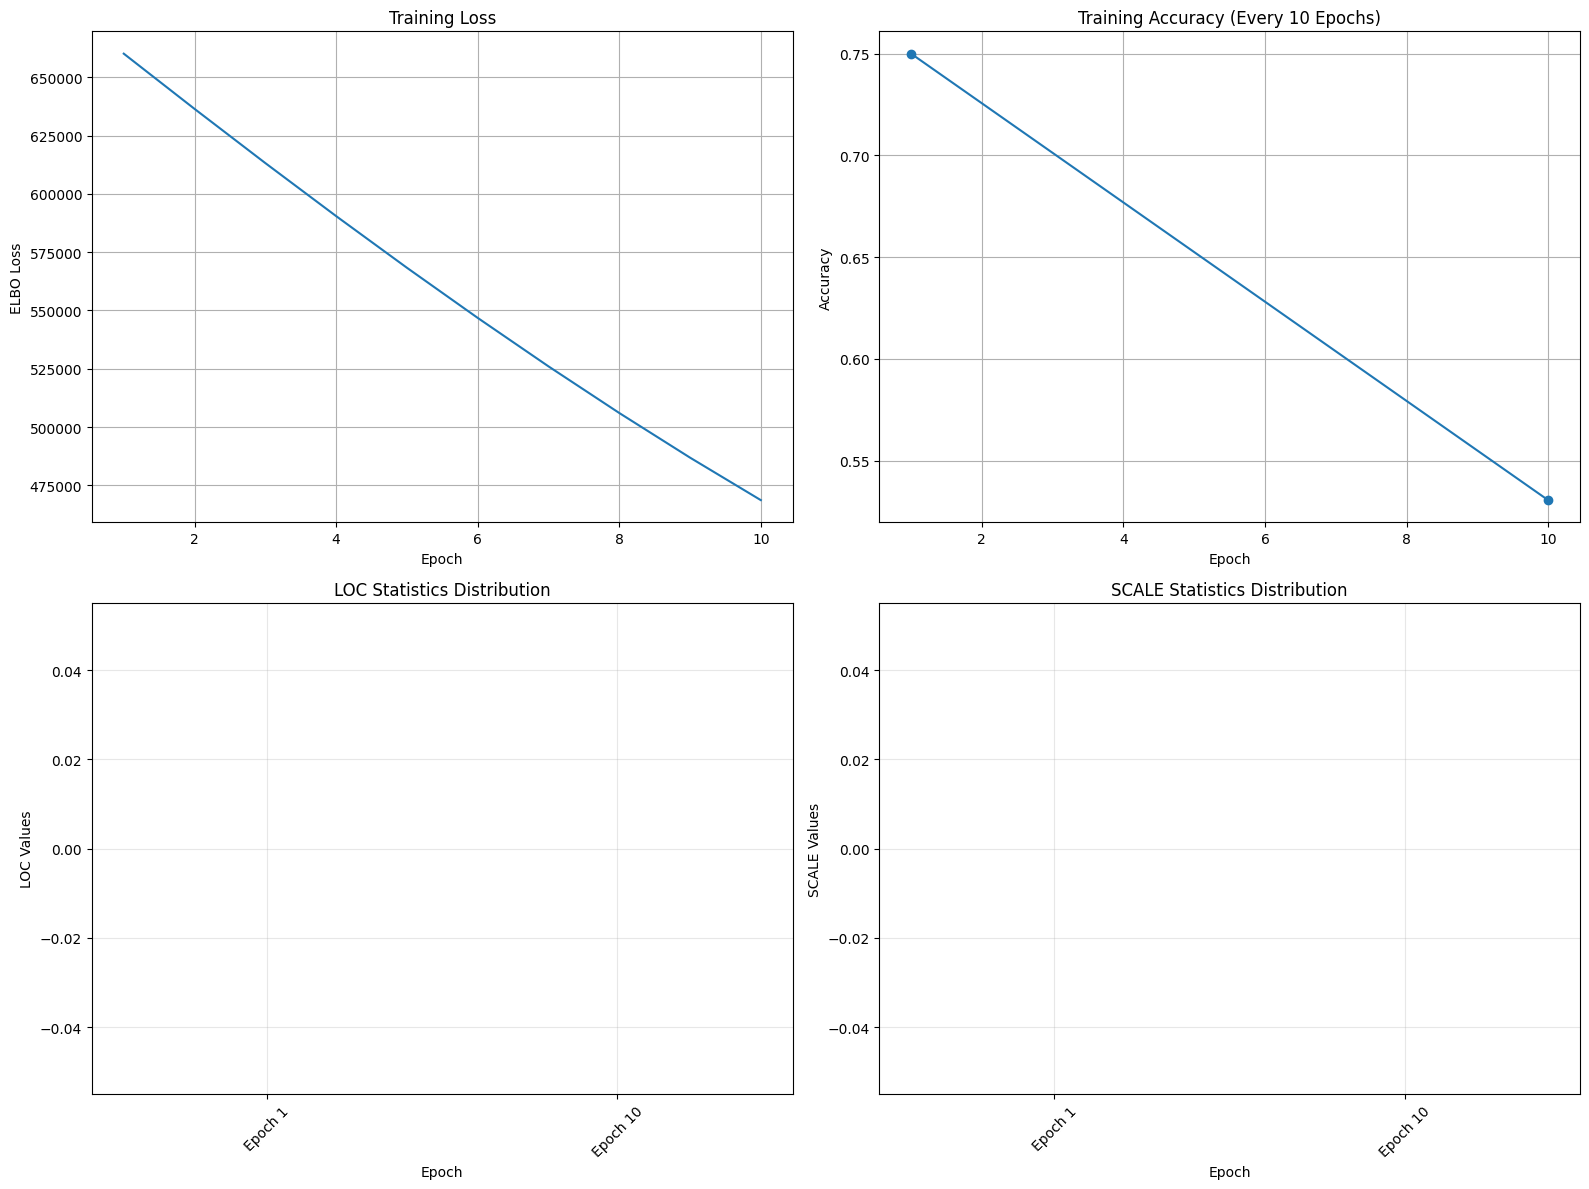

In [11]:
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#'rwg','wg',
for activation_iter in ['laplace']:
    for prior_iter in ['relu']:
        for b_iter in [10.0]:
            pyro.clear_param_store()

            # print log to annoounce what experiment is running
            print("==========================================")
            print(f"Running experiment with activation={prior_iter}, prior={activation_iter}, b={b_iter}")
            print("==========================================")
            bayesian_model = BayesShipsCNN(num_classes,
                    device,
                    activation=prior_iter,
                    prior_dist=activation_iter,
                    mu = 0.0,
                    b= b_iter,
                    #prior_params={'mu': 0.0, 'b': b_iter})
                    )
            
            # 1) construct your guide so its locs start at p(w).mean=0
            #guide = AutoLaplace(bayesian_model)

            #optimizer = Adam({"lr": 1e-3,
            #                    "weight_decay": 1e-4})  # Increased from 1e-4 to 1e-3, weight decay added
            
            guide = AutoUniform(bayesian_model, init_scale=0.05).to(device)
            optimizer = ClippedAdam({"lr": 1e-3})
            
            svi = pyro.infer.SVI(model=bayesian_model,
                                guide=guide,
                                optim=optimizer,
                                loss=pyro.infer.Trace_ELBO(num_particles=1,
                                                            )) #TODO

            pyro.clear_param_store()

            # Ensure model and guide are on the correct device
            bayesian_model.to(device)
            guide.to(device)

            train_loader, test_loader = load_data(batch_size=16)
            
            losses, accuracies, accuracy_epochs, weight_stats, bias_stats, best_model_path, best_guide_path, best_param_store_path, experiment_timestamp = train_svi_with_stats(
            bayesian_model,
            guide,
            svi,
            train_loader,
            device,
            num_epochs=10,
            save_epochs=None,
            save_dir='results_GP_shipsnet')
            
            act_name = bayesian_model.activation_fn.__name__ if hasattr(bayesian_model.activation_fn, '__name__') else str(bayesian_model.activation_fn)
            prior_name = getattr(bayesian_model, 'prior_dist', 'prior')

            plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats, act_name, prior_name, experiment_timestamp)

In [12]:
# print pyro param store name and shape
for name, param in pyro.get_param_store().items():
        print(f"{name}: {param.shape}")

AutoUniform.lows.conv1.weight: torch.Size([32, 3, 3, 3])
AutoUniform.widths.conv1.weight: torch.Size([32, 3, 3, 3])
AutoUniform.lows.conv1.bias: torch.Size([32])
AutoUniform.widths.conv1.bias: torch.Size([32])
AutoUniform.lows.conv2.weight: torch.Size([64, 32, 3, 3])
AutoUniform.widths.conv2.weight: torch.Size([64, 32, 3, 3])
AutoUniform.lows.conv2.bias: torch.Size([64])
AutoUniform.widths.conv2.bias: torch.Size([64])
AutoUniform.lows.conv3.weight: torch.Size([128, 64, 3, 3])
AutoUniform.widths.conv3.weight: torch.Size([128, 64, 3, 3])
AutoUniform.lows.conv3.bias: torch.Size([128])
AutoUniform.widths.conv3.bias: torch.Size([128])
AutoUniform.lows.fc1.weight: torch.Size([256, 128])
AutoUniform.widths.fc1.weight: torch.Size([256, 128])
AutoUniform.lows.fc1.bias: torch.Size([256])
AutoUniform.widths.fc1.bias: torch.Size([256])
AutoUniform.lows.fc2.weight: torch.Size([2, 256])
AutoUniform.widths.fc2.weight: torch.Size([2, 256])
AutoUniform.lows.fc2.bias: torch.Size([2])
AutoUniform.widths.

In [13]:
pyro_parameter_values = {}

for name, value in pyro.get_param_store().items():
    pyro_parameter_values[name.replace("AutoUniform.","")] = value.cpu().detach().numpy()

In [14]:
from pyro.infer import Predictive

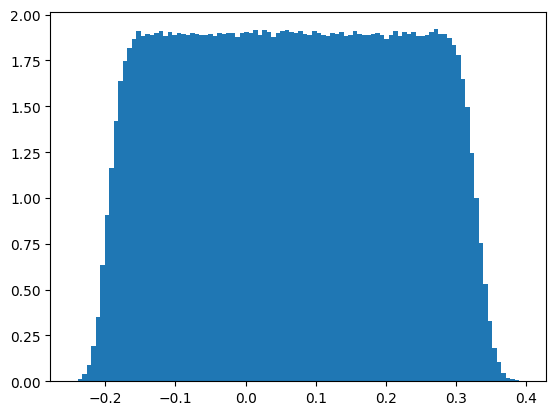

In [15]:
# 2) Grab one batch of images
images, labels = next(iter(train_loader))
images = images.to(device)

# 3) Build a Predictive that uses your trained guide
predictive = Predictive(model=bayesian_model, guide=guide, num_samples=2000)

# 4) Draw samples
samples = predictive(images)              # dict of sites → Tensors
w_samples = samples["conv1.weight"]      # shape [2000, 32,3,3]

# 5) Now you can flatten & plot
data = w_samples.cpu().numpy().ravel()
plt.hist(data, bins=100, density=True)
plt.show()